# Interactive Global Trade Simulation

This notebook provides an interactive interface to simulate global trade dynamics with adjustable parameters:

- **Number of countries**: Customize the scale of the simulation
- **Tariff policies**: Test different trade policies and their effects
- **Friendship thresholds**: Adjust relationship dynamics between countries
- **Connection probability**: Change the initial network density

The simulation includes analytics to determine if the world economy is unipolar (dominated by one country/bloc) or multipolar (balanced between multiple power centers).

# Add logic that it's expensive to ship to farther countries and that landlocked countries have higher transaction costs.

Maybe also add govt/ politics as an constant factor

# Global Trade Network Simulation

This notebook simulates international trade relationships between countries as a dynamic network. The simulation models:

- **Friendship relationships** between countries (ranging from 0 to 1)
- **Tariffs** applied to trade between countries (inversely related to friendship)
- **Transaction costs** for trade between countries

The simulation demonstrates how trade relationships evolve over time based on interaction patterns, showing the emergence of trade communities and the effects of economic policies.

In [30]:
# Import libraries for interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns

# For community detection
try:
    from community import community_louvain
except ImportError:
    print("Installing community detection package...")
    !pip install python-louvain
    try:
        from community import community_louvain
    except ImportError:
        print("Could not import community_louvain - community detection functionality will be limited")

# Initialize the global trade network
np.random.seed(42)  # For reproducibility
num_countries = 193
countries = [f"Country_{i}" for i in range(num_countries)]

# Create a directed graph to represent trade relationships
G = nx.DiGraph()
G.add_nodes_from(countries)

# Initialize random friendship strengths (0-1) between countries
friendship_matrix = np.random.random((num_countries, num_countries)) * 0.5 + 0.5  # Values between 0.5 and 1
friendship_threshold = 0.2  # Below this, trade relationship breaks

# Make friendship symmetric and set diagonal to 1 (self-friendship)
friendship_matrix = (friendship_matrix + friendship_matrix.T) / 2
np.fill_diagonal(friendship_matrix, 1.0)

# Initial trade connections - not all countries have direct trade
connection_probability = 0.05  # Sparse initial connections
for i in range(num_countries):
    for j in range(num_countries):
        if i != j and np.random.random() < connection_probability:
            # Add edge with base transaction cost and tariff based on friendship
            tariff = 1.0 - friendship_matrix[i, j]**2  # Friendship strongly reduces tariff
            
            # Generate a random distance factor (representing geographic distance)
            distance = np.random.random() * 10  # Random distance between 0-10 units
            
            # Add edge with all attributes
            G.add_edge(countries[i], countries[j], 
                      friendship=friendship_matrix[i, j],
                      tariff=tariff,
                      distance=distance,
                      transaction_cost=0.05 + 0.1 * np.random.random())  # Base transaction cost

# Function to update the network for each simulation step
def update_network(G, friendship_matrix, step):
    # 1. Trade affects friendship
    for u, v, data in list(G.edges(data=True)):
        i = countries.index(u)
        j = countries.index(v)
        
        # Tariffs reduce friendship
        friendship_matrix[i, j] -= data['tariff'] * 0.01
        friendship_matrix[j, i] = friendship_matrix[i, j]  # Keep symmetric
        
        # Update friendship in the graph
        data['friendship'] = friendship_matrix[i, j]
        
        # Update tariff based on new friendship
        data['tariff'] = 1.0 - friendship_matrix[i, j]**2
        
        # Remove edge if friendship falls below threshold
        if friendship_matrix[i, j] < friendship_threshold:
            G.remove_edge(u, v)
    
    # 2. Random new trade connections emerge
    if step % 5 == 0:  # Every 5 steps
        for _ in range(int(num_countries * 0.02)):  # 2% of countries form new connections
            i = np.random.randint(0, num_countries)
            j = np.random.randint(0, num_countries)
            if i != j and not G.has_edge(countries[i], countries[j]):
                # New trade relationship based on current friendship
                tariff = 1.0 - friendship_matrix[i, j]**2
                distance = np.random.random() * 10  # Random distance between 0-10 units
                G.add_edge(countries[i], countries[j],
                          friendship=friendship_matrix[i, j],
                          tariff=tariff,
                          distance=distance,
                          transaction_cost=0.05 + 0.1 * np.random.random())
    
    # 3. Ensure friendship stays in valid range [0,1]
    friendship_matrix = np.clip(friendship_matrix, 0, 1)
    
    return G, friendship_matrix

# Function to visualize the network
def plot_network(G):
    plt.figure(figsize=(12, 10))
    
    # Use friendship as edge weight for visualization
    edge_weights = [G[u][v]['friendship']*3 for u, v in G.edges()]
    
    # Color edges based on tariffs (red=high tariff, green=low tariff)
    edge_colors = [plt.cm.RdYlGn(1-G[u][v]['tariff']) for u, v in G.edges()]
    
    # Layout with weighted edges
    pos = nx.spring_layout(G, weight='friendship', k=0.2, seed=42)  # Add seed for reproducibility
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color=edge_colors, 
                          arrowsize=5, connectionstyle="arc3,rad=0.1")
    
    plt.title(f"Global Trade Network - {G.number_of_edges()} trade relationships")
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

# Simulation function for animation
def simulate(num_steps=100):
    global G, friendship_matrix
    
    stats = {
        'steps': [],
        'num_edges': [],
        'avg_friendship': [],
        'avg_tariff': []
    }
    
    for step in range(num_steps):
        G, friendship_matrix = update_network(G, friendship_matrix, step)
        
        # Collect statistics
        if step % 5 == 0:
            stats['steps'].append(step)
            stats['num_edges'].append(G.number_of_edges())
            
            if G.number_of_edges() > 0:
                avg_friendship = np.mean([G[u][v]['friendship'] for u, v in G.edges()])
                avg_tariff = np.mean([G[u][v]['tariff'] for u, v in G.edges()])
                stats['avg_friendship'].append(avg_friendship)
                stats['avg_tariff'].append(avg_tariff)
            else:
                stats['avg_friendship'].append(0)
                stats['avg_tariff'].append(0)
    
    return stats

# Interactive parameters UI
def create_simulation_ui():
    # Define widgets for simulation parameters
    num_countries_slider = widgets.IntSlider(
        value=50,
        min=10,
        max=200,
        step=5,
        description='Countries:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    friendship_threshold_slider = widgets.FloatSlider(
        value=0.2,
        min=0.05,
        max=0.5,
        step=0.05,
        description='Friendship Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    connection_probability_slider = widgets.FloatSlider(
        value=0.05,
        min=0.01,
        max=0.2,
        step=0.01,
        description='Initial Connection Probability:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    num_steps_slider = widgets.IntSlider(
        value=100,
        min=20,
        max=500,
        step=20,
        description='Simulation Steps:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    # Tariff policy dropdown
    tariff_policy = widgets.Dropdown(
        options=[
            ('Friendship-based (Default)', 'default'),
            ('High Tariffs for All', 'high'),
            ('Low Tariffs for All', 'low'),
            ('Random Tariffs', 'random'),
            ('Bloc-based Tariffs', 'bloc')
        ],
        value='default',
        description='Tariff Policy:',
        style={'description_width': 'initial'}
    )
    
    # Country to apply special tariff policy to
    special_tariff_country = widgets.IntText(
        value=0,
        description='Special Tariff Country ID:',
        style={'description_width': 'initial'}
    )
    
    special_tariff_value = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Special Tariff Value:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
    
    # Apply button
    apply_button = widgets.Button(
        description='Run Simulation',
        button_style='success',
        tooltip='Click to run the simulation with these parameters'
    )
    
    # Output widget for displaying results
    output = widgets.Output()
    
    # Group related controls
    basic_params = widgets.VBox([
        widgets.HTML(value="<b>Basic Parameters</b>"),
        num_countries_slider,
        friendship_threshold_slider,
        connection_probability_slider,
        num_steps_slider
    ])
    
    tariff_params = widgets.VBox([
        widgets.HTML(value="<b>Tariff Policies</b>"),
        tariff_policy,
        special_tariff_country,
        special_tariff_value
    ])
    
    # Arrange widgets in tabs
    tab = widgets.Tab()
    tab.children = [basic_params, tariff_params]
    tab.set_title(0, 'Basic Parameters')
    tab.set_title(1, 'Tariff Policies')
    
    # Main UI layout
    ui = widgets.VBox([
        tab,
        apply_button,
        output
    ])
    
    # Return all widgets for later access
    params = {
        'num_countries': num_countries_slider,
        'friendship_threshold': friendship_threshold_slider,
        'connection_probability': connection_probability_slider,
        'num_steps': num_steps_slider,
        'tariff_policy': tariff_policy,
        'special_tariff_country': special_tariff_country,
        'special_tariff_value': special_tariff_value,
        'apply_button': apply_button,
        'output': output
    }
    
    return ui, params

In [40]:
# Display the UI
ui, params = create_simulation_ui()
display(ui)

# Function to initialize the simulation with the given parameters
def initialize_simulation(num_countries, friendship_threshold, connection_probability, 
                         tariff_policy='default', special_country=None, special_tariff=None):
    # Create a directed graph to represent trade relationships
    G = nx.DiGraph()
    
    # Create country nodes
    countries = [f"Country_{i}" for i in range(num_countries)]
    G.add_nodes_from(countries)
    
    # Initialize random friendship strengths (0-1) between countries
    friendship_matrix = np.random.random((num_countries, num_countries)) * 0.5 + 0.5  # Values between 0.5 and 1
    
    # Make friendship symmetric and set diagonal to 1 (self-friendship)
    friendship_matrix = (friendship_matrix + friendship_matrix.T) / 2
    np.fill_diagonal(friendship_matrix, 1.0)
    
    # Initialize reciprocal tariff tracking
    reciprocal_tariffs = {}
    
    # Initial trade connections - not all countries have direct trade
    for i in range(num_countries):
        for j in range(num_countries):
            if i != j and np.random.random() < connection_probability:
                # Distance factor representing geographic distance
                distance = np.random.random() * 10  # Random distance between 0-10 units
                
                # Set tariff based on the selected policy
                if tariff_policy == 'default':
                    # Default: Friendship-based tariffs
                    tariff = 1.0 - friendship_matrix[i, j]**2
                elif tariff_policy == 'high':
                    # High tariffs for all
                    tariff = 0.7 + 0.3 * np.random.random()
                elif tariff_policy == 'low':
                    # Low tariffs for all
                    tariff = 0.3 * np.random.random()
                elif tariff_policy == 'random':
                    # Random tariffs
                    tariff = np.random.random()
                elif tariff_policy == 'bloc':
                    # Bloc-based tariffs (countries in "regions" have lower tariffs)
                    region_i = i % 5  # Assume 5 distinct regions
                    region_j = j % 5
                    if region_i == region_j:  # Same region
                        tariff = 0.2 * np.random.random()
                    else:  # Different regions
                        tariff = 0.5 + 0.5 * np.random.random()
                
                # Apply special tariff if applicable
                if special_country is not None and special_tariff is not None:
                    if i == special_country:
                        tariff = special_tariff
                
                # Calculate transaction cost based on distance
                transaction_cost = 0.05 + 0.1 * np.random.random() + distance * 0.01
                
                # Add edge with all attributes
                G.add_edge(countries[i], countries[j], 
                          friendship=friendship_matrix[i, j],
                          tariff=tariff,
                          distance=distance,
                          transaction_cost=transaction_cost,
                          is_reciprocal=False)  # Track if this is a reciprocal tariff
    
    # Apply reciprocal tariffs based on the new formula
    apply_reciprocal_tariffs(G, countries)
    
    return G, friendship_matrix, countries

# Function to apply reciprocal tariffs
def apply_reciprocal_tariffs(G, countries):
    """
    Apply reciprocal tariffs based on the formula:
    If a country tariffs you:
        If you have no other edge: No reciprocal tariff
        If other edges: Prob of reciprocal tariff = (no. edges / max edges for a node) * 100%
    """
    # First, find the maximum possible edges for any node
    max_possible_edges = len(countries) - 1
    
    # Process each country
    for country in countries:
        # Get all incoming edges (other countries that apply tariffs to this country)
        incoming_edges = list(G.in_edges(country, data=True))
        
        # Get outgoing edges count (countries this country trades with)
        outgoing_edges = list(G.out_edges(country, data=True))
        outgoing_count = len(outgoing_edges)
        
        # Skip if no outgoing edges (can't apply reciprocal tariffs)
        if outgoing_count == 0:
            continue
        
        # For each incoming tariff, decide if to apply a reciprocal tariff
        for source, target, edge_data in incoming_edges:
            # Skip if there's already a reciprocal relationship
            if G.has_edge(target, source) and G[target][source].get('is_reciprocal', False):
                continue
                
            # Calculate probability of reciprocal tariff
            # If only one edge, no reciprocal tariff
            if outgoing_count <= 1:
                probability = 0.0
            else:
                # Probability increases with the number of trade partners
                probability = outgoing_count / max_possible_edges
            
            # Apply reciprocal tariff with calculated probability
            if np.random.random() < probability and not G.has_edge(target, source):
                # Apply a slightly higher tariff in retaliation
                reciprocal_tariff = min(edge_data['tariff'] * 1.2, 1.0)
                
                # Create reciprocal edge with tariff
                G.add_edge(target, source,
                          friendship=edge_data['friendship'],  # Use same friendship
                          tariff=reciprocal_tariff,
                          distance=edge_data.get('distance', 5.0),  # Use same distance if available
                          transaction_cost=edge_data.get('transaction_cost', 0.1),
                          is_reciprocal=True)  # Mark as reciprocal

In [32]:
# Enhanced simulation function with new parameters
def simulate_with_params(G, friendship_matrix, countries, num_steps=100, friendship_threshold=0.2):
    stats = {
        'steps': [],
        'num_edges': [],
        'avg_friendship': [],
        'avg_tariff': [],
        'num_communities': [],
        'largest_community_size': [],
        'polarity_index': [],  # New metric for uni/multipolar analysis
        'reciprocal_ratio': []  # Track ratio of reciprocal tariffs
    }
    
    for step in range(num_steps):
        # 1. Trade affects friendship
        for u, v, data in list(G.edges(data=True)):
            i = countries.index(u)
            j = countries.index(v)
            
            # Tariffs reduce friendship
            friendship_matrix[i, j] -= data['tariff'] * 0.01
            friendship_matrix[j, i] = friendship_matrix[i, j]  # Keep symmetric
            
            # Update friendship in the graph
            data['friendship'] = friendship_matrix[i, j]
            
            # Update tariff based on new friendship
            data['tariff'] = 1.0 - friendship_matrix[i, j]**2
            
            # Remove edge if friendship falls below threshold
            if friendship_matrix[i, j] < friendship_threshold:
                G.remove_edge(u, v)
        
        # 2. Random new trade connections emerge
        if step % 5 == 0:  # Every 5 steps
            for _ in range(int(len(countries) * 0.02)):  # 2% of countries form new connections
                i = np.random.randint(0, len(countries))
                j = np.random.randint(0, len(countries))
                if i != j and not G.has_edge(countries[i], countries[j]):
                    # New trade relationship based on current friendship
                    tariff = 1.0 - friendship_matrix[i, j]**2
                    distance = np.random.random() * 10
                    G.add_edge(countries[i], countries[j],
                              friendship=friendship_matrix[i, j],
                              tariff=tariff,
                              distance=distance,
                              transaction_cost=0.05 + 0.1 * np.random.random() + distance * 0.01,
                              is_reciprocal=False)  # Normal trade relationship
        
        # 3. Apply reciprocal tariffs periodically
        if step % 10 == 0:
            apply_reciprocal_tariffs(G, countries)
        
        # 4. Ensure friendship stays in valid range [0,1]
        friendship_matrix = np.clip(friendship_matrix, 0, 1)
        
        # Collect statistics 
        if step % 5 == 0:
            stats['steps'].append(step)
            stats['num_edges'].append(G.number_of_edges())
            
            if G.number_of_edges() > 0:
                avg_friendship = np.mean([G[u][v]['friendship'] for u, v in G.edges()])
                avg_tariff = np.mean([G[u][v]['tariff'] for u, v in G.edges()])
                stats['avg_friendship'].append(avg_friendship)
                stats['avg_tariff'].append(avg_tariff)
                
                # Calculate ratio of reciprocal tariffs
                reciprocal_edges = sum(1 for u, v, data in G.edges(data=True) if data.get('is_reciprocal', False))
                stats['reciprocal_ratio'].append(reciprocal_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0)
                
                # Analyze communities if there are edges
                if G.number_of_edges() > 10:  # Need minimum edges for meaningful community detection
                    G_undir = G.to_undirected()
                    try:
                        # Detect communities using Louvain method
                        partition = community_louvain.best_partition(G_undir)
                        communities = set(partition.values())
                        num_communities = len(communities)
                        
                        # Count community sizes
                        community_sizes = {}
                        for com in communities:
                            size = sum(1 for node in partition if partition[node] == com)
                            community_sizes[com] = size
                        
                        largest_community_size = max(community_sizes.values())
                        
                        # Calculate polarity index (ratio of largest community to total nodes)
                        polarity_index = largest_community_size / len(countries)
                        
                        stats['num_communities'].append(num_communities)
                        stats['largest_community_size'].append(largest_community_size)
                        stats['polarity_index'].append(polarity_index)
                    except:
                        # Fallback if community detection fails
                        stats['num_communities'].append(0)
                        stats['largest_community_size'].append(0)
                        stats['polarity_index'].append(0)
                else:
                    stats['num_communities'].append(0)
                    stats['largest_community_size'].append(0)
                    stats['polarity_index'].append(0)
            else:
                stats['avg_friendship'].append(0)
                stats['avg_tariff'].append(0)
                stats['num_communities'].append(0)
                stats['largest_community_size'].append(0)
                stats['polarity_index'].append(0)
                stats['reciprocal_ratio'].append(0)
    
    return G, friendship_matrix, stats

In [41]:
simulate_with_params(G, friendship_matrix, countries, num_steps=100, friendship_threshold=0.2)

(<networkx.classes.digraph.DiGraph at 0x1380fab90>,
 array([[1.        , 0.89595394, 0.75350713, ..., 0.56489836, 0.7360296 ,
         0.9470411 ],
        [0.89595394, 1.        , 0.63166228, ..., 0.86464161, 0.77892928,
         0.8250461 ],
        [0.75350713, 0.63166228, 1.        , ..., 0.59487589, 0.75668137,
         0.87010973],
        ...,
        [0.56489836, 0.86464161, 0.59487589, ..., 1.        , 0.71234162,
         0.87712078],
        [0.7360296 , 0.77892928, 0.75668137, ..., 0.71234162, 1.        ,
         0.19349529],
        [0.9470411 , 0.8250461 , 0.87010973, ..., 0.87712078, 0.19349529,
         1.        ]], shape=(193, 193)),
 {'steps': [0,
   5,
   10,
   15,
   20,
   25,
   30,
   35,
   40,
   45,
   50,
   55,
   60,
   65,
   70,
   75,
   80,
   85,
   90,
   95],
  'num_edges': [418,
   352,
   312,
   258,
   224,
   195,
   174,
   153,
   136,
   123,
   112,
   103,
   88,
   80,
   78,
   74,
   67,
   63,
   59,
   58],
  'avg_friendship': [np.f

## Basic Network Simulation and Visualization

Below, we run a 100-step simulation of the global trade network and visualize the results. The simulation shows:

1. The network graph of trade relationships between countries
2. The evolution of the number of trade relationships over time
3. Changes in average friendship and tariff levels

As the simulation progresses, countries with stronger friendships maintain lower tariffs, while countries with weaker relationships may lose trade connections entirely.

In [42]:
# Run a short simulation and visualize results
def run_and_visualize(num_steps=100):
    stats = simulate(num_steps)
    
    # Create a figure with proper spacing
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('Global Trade Network Simulation Results', fontsize=16)
    
    # Add subplot for network visualization
    ax1 = fig.add_subplot(2, 1, 1)
    # Get network figure and display in the right subplot
    network_fig = plot_network(G)
    plt.close(network_fig)  # Close the separate figure
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title(f"Global Trade Network - {G.number_of_edges()} relationships")
    ax1.axis('off')
    
    # Add subplot for edge count over time
    ax2 = fig.add_subplot(2, 2, 3)
    ax2.plot(stats['steps'], stats['num_edges'], 'b-', linewidth=2)
    ax2.set_title('Number of Trade Relationships')
    ax2.set_xlabel('Simulation Steps')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Add subplot for friendship and tariff
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(stats['steps'], stats['avg_friendship'], 'g-', linewidth=2, label='Avg Friendship')
    ax3.plot(stats['steps'], stats['avg_tariff'], 'r-', linewidth=2, label='Avg Tariff')
    ax3.set_title('Trade Relationship Metrics')
    ax3.set_xlabel('Simulation Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print summary statistics
    if G.number_of_edges() > 0:
        print(f"\nSummary Statistics after {num_steps} steps:")
        print(f"  - Final number of trade relationships: {G.number_of_edges()}")
        print(f"  - Average friendship level: {stats['avg_friendship'][-1]:.4f}")
        print(f"  - Average tariff level: {stats['avg_tariff'][-1]:.4f}")
        
        # Calculate network density
        density = nx.density(G)
        print(f"  - Network density: {density:.4f}")
        
        # Calculate reciprocity (proportion of bilateral trade relationships)
        reciprocity = nx.reciprocity(G)
        print(f"  - Trade reciprocity: {reciprocity:.4f}")
    else:
        print("No trade relationships remain after the simulation.")

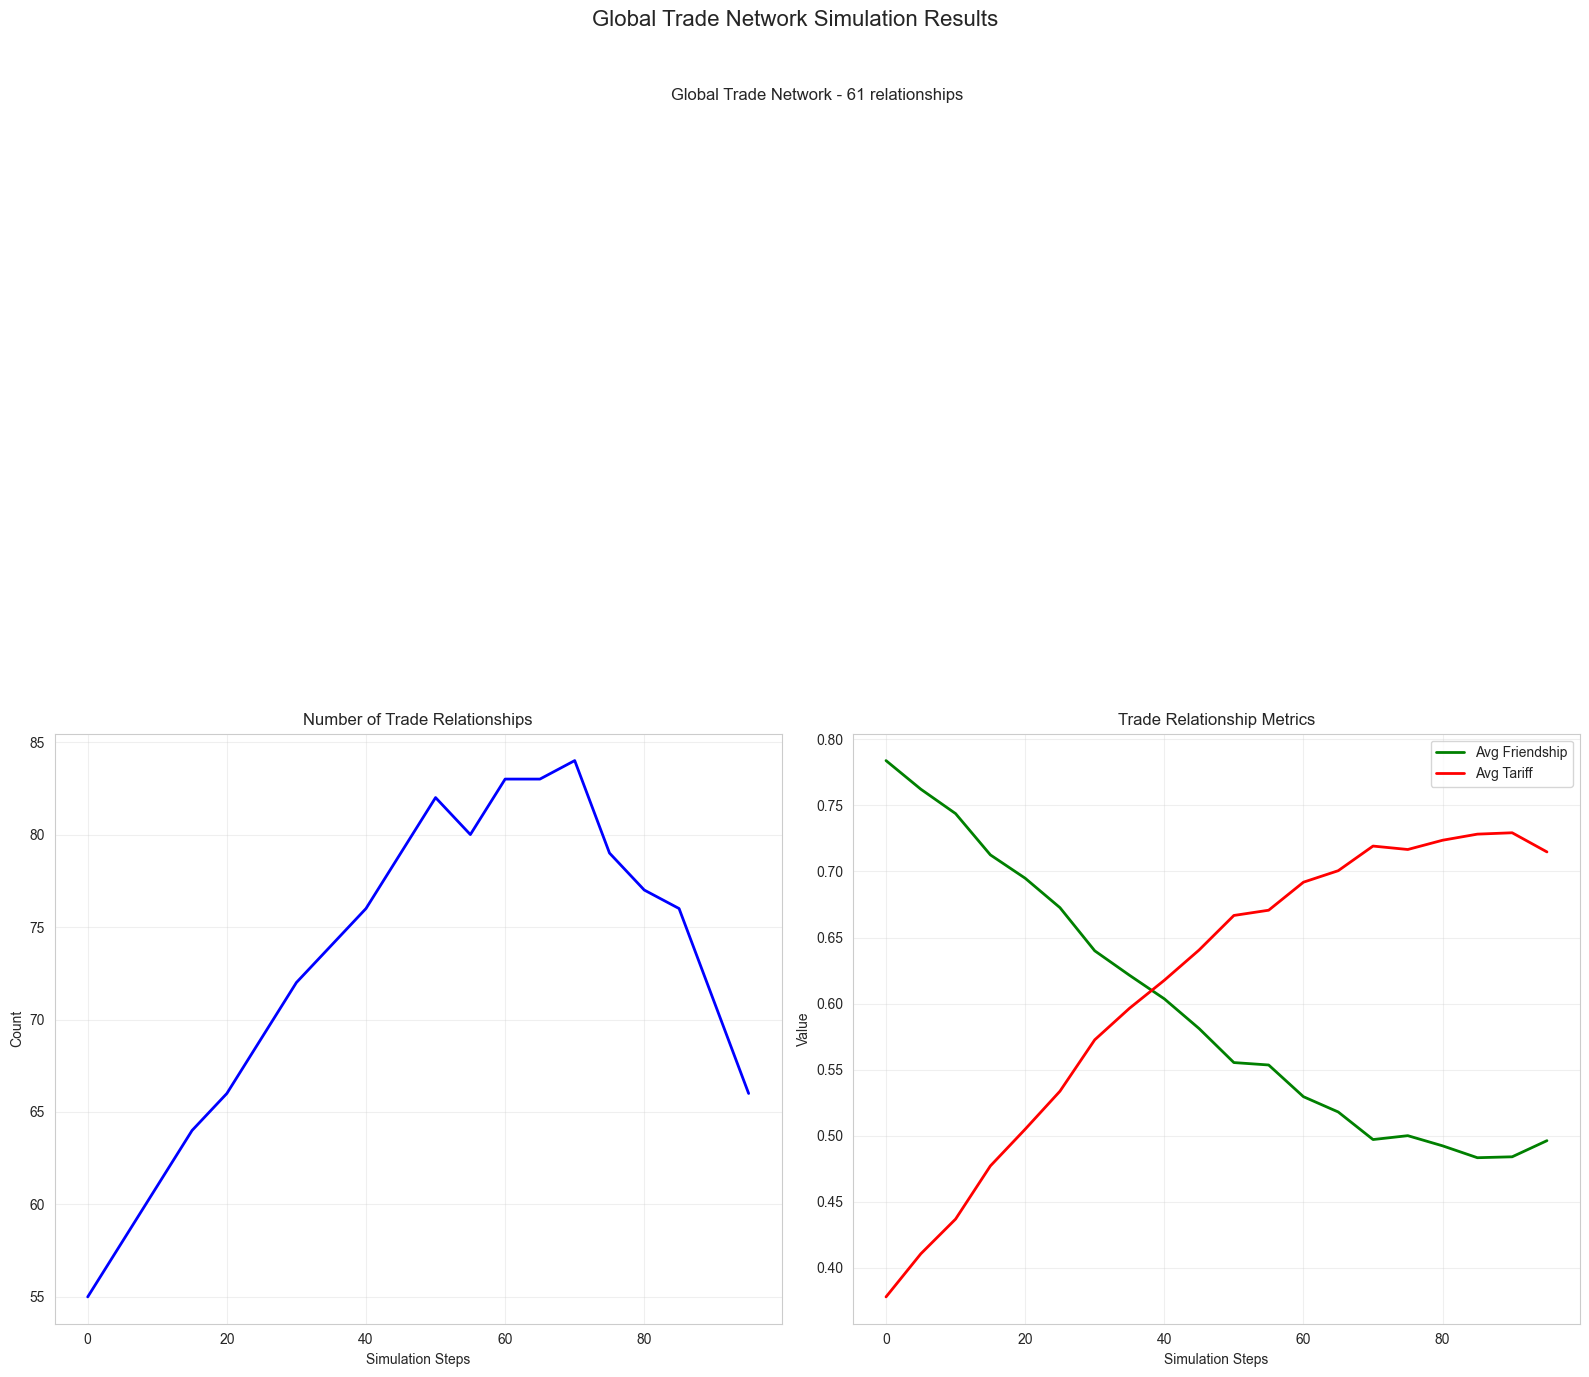


Summary Statistics after 100 steps:
  - Final number of trade relationships: 61
  - Average friendship level: 0.4962
  - Average tariff level: 0.7148
  - Network density: 0.0016
  - Trade reciprocity: 0.0000


In [43]:
run_and_visualize(100)

## Analyzing Geographic Distance Effects

Distance plays a crucial role in international trade. Countries that are geographically closer tend to trade more frequently and with lower transaction costs. In our simulation, we explore the relationship between:

- Geographic distance between countries
- Transaction costs of trade
- Tariff levels

The analysis below shows how distance correlates with these economic factors.

In [44]:
# Analyze the relationship between distance and transaction cost
def analyze_distance_effect():
    if G.number_of_edges() > 0:
        # Safely extract edge attributes
        edges_data = []
        for u, v, data in G.edges(data=True):
            # Check if all required attributes exist
            if all(attr in data for attr in ['distance', 'transaction_cost', 'tariff', 'friendship']):
                edges_data.append({
                    'Distance': data['distance'],
                    'Transaction Cost': data['transaction_cost'],
                    'Tariff': data['tariff'],
                    'Friendship': data['friendship']
                })
        
        # Create DataFrame for analysis
        if edges_data:
            df = pd.DataFrame(edges_data)
            
            # Set up a nice style for the plots
            sns.set_style('whitegrid')
            
            # Create a figure with multiple subplots
            fig = plt.figure(figsize=(16, 12))
            fig.suptitle('Impact of Geographic Distance on Trade Relationships', fontsize=16)
            
            # Plot 1: Distance vs. Transaction Cost
            ax1 = fig.add_subplot(2, 2, 1)
            sns.scatterplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, alpha=0.6)
            sns.regplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, scatter=False, color='red')
            ax1.set_title('Distance vs. Transaction Cost')
            
            # Plot 2: Distance vs. Tariff
            ax2 = fig.add_subplot(2, 2, 2)
            sns.scatterplot(x='Distance', y='Tariff', data=df, ax=ax2, alpha=0.6)
            sns.regplot(x='Distance', y='Tariff', data=df, ax=ax2, scatter=False, color='red')
            ax2.set_title('Distance vs. Tariff')
            
            # Plot 3: Distance vs. Friendship
            ax3 = fig.add_subplot(2, 2, 3)
            sns.scatterplot(x='Distance', y='Friendship', data=df, ax=ax3, alpha=0.6)
            sns.regplot(x='Distance', y='Friendship', data=df, ax=ax3, scatter=False, color='red')
            ax3.set_title('Distance vs. Friendship')
            
            # Plot 4: Transaction Cost vs. Tariff
            ax4 = fig.add_subplot(2, 2, 4)
            sns.scatterplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, alpha=0.6)
            sns.regplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, scatter=False, color='red')
            ax4.set_title('Transaction Cost vs. Tariff')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
            plt.show()
            
            # Calculate correlations
            print("Correlation Analysis:")
            corr_matrix = df.corr()
            print(corr_matrix.round(4))
            
            # Calculate average transaction costs by distance quartiles
            print("\nTransaction Costs by Distance Quartile:")
            df['Distance Quartile'] = pd.qcut(df['Distance'], 4, labels=['Q1 (Closest)', 'Q2', 'Q3', 'Q4 (Farthest)'])
            quartile_stats = df.groupby('Distance Quartile').agg({
                'Transaction Cost': 'mean',
                'Tariff': 'mean',
                'Friendship': 'mean'
            })
            
            print(quartile_stats.round(4))
        else:
            print("Graph edges don't have the required attributes (distance, transaction_cost, tariff).")
    else:
        print("No edges in the network to analyze.")

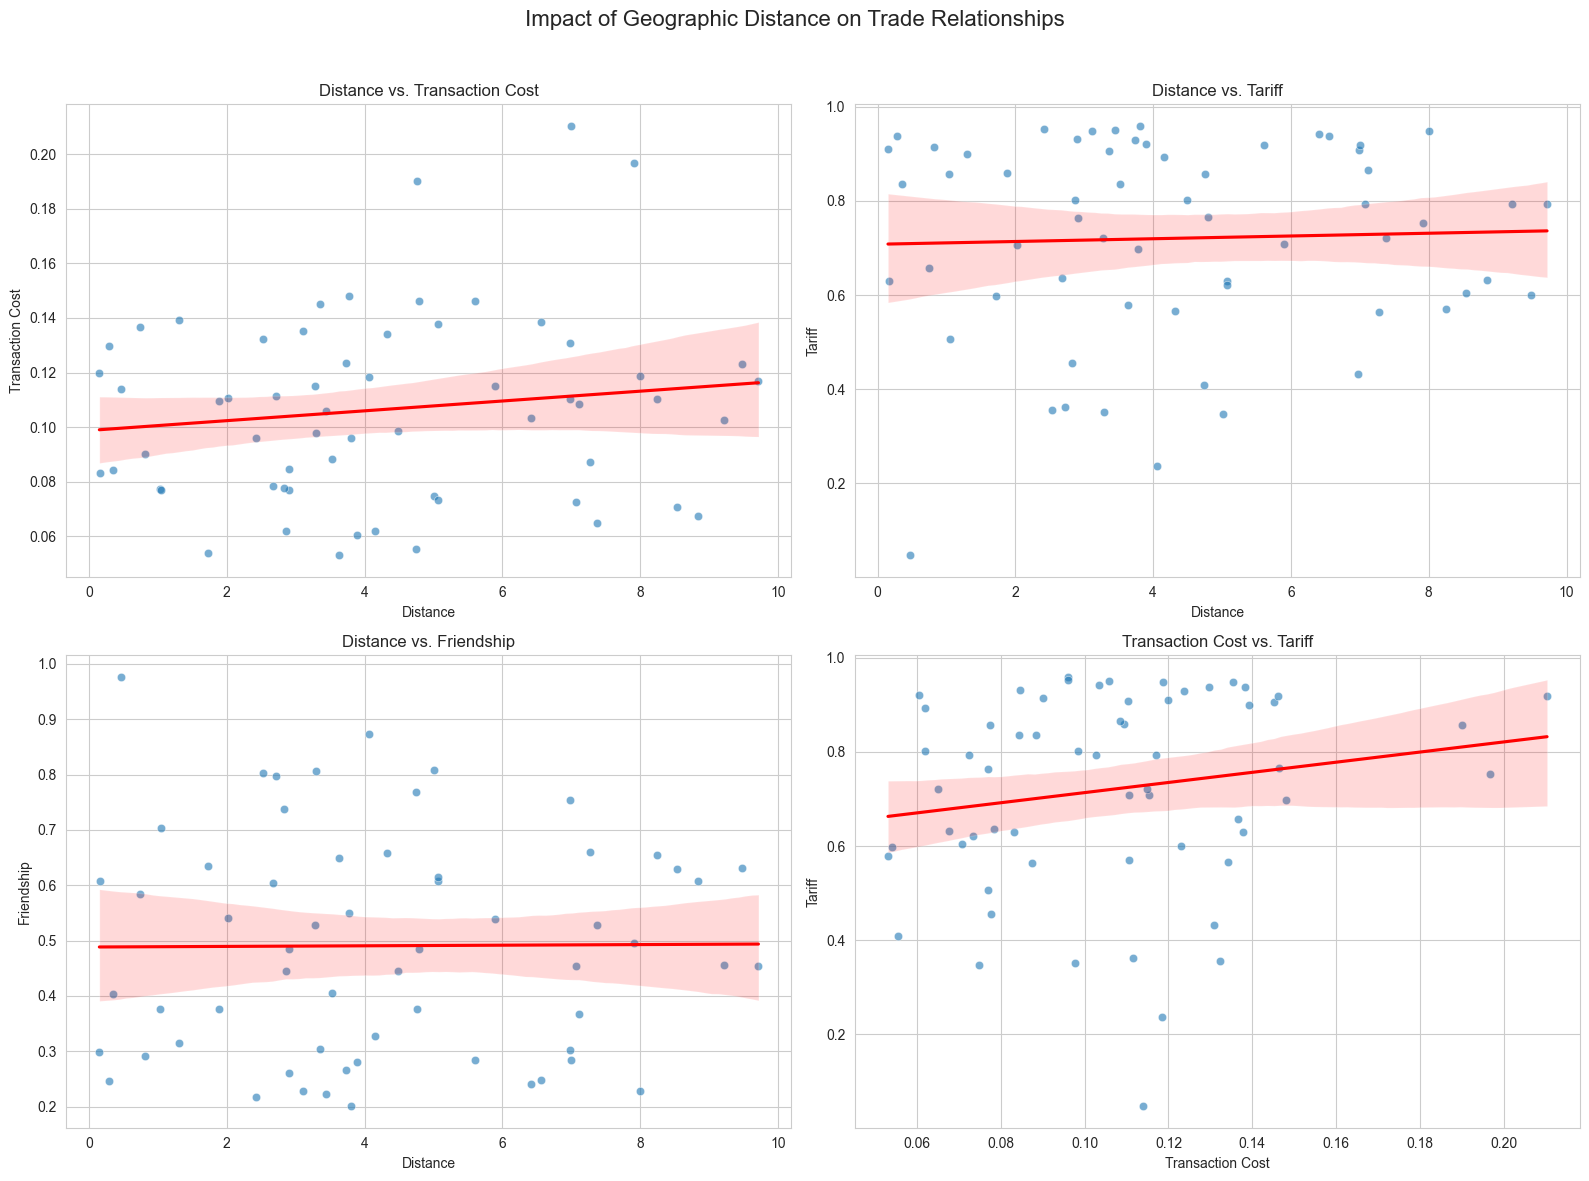

Correlation Analysis:
                  Distance  Transaction Cost  Tariff  Friendship
Distance            1.0000            0.1380  0.0365      0.0073
Transaction Cost    0.1380            1.0000  0.1750     -0.1977
Tariff              0.0365            0.1750  1.0000     -0.9822
Friendship          0.0073           -0.1977 -0.9822      1.0000

Transaction Costs by Distance Quartile:
                   Transaction Cost  Tariff  Friendship
Distance Quartile                                      
Q1 (Closest)                 0.1020  0.7068      0.4987
Q2                           0.1014  0.7463      0.4593
Q3                           0.1103  0.7039      0.5039
Q4 (Farthest)                0.1128  0.7265      0.5006


/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/471213971.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = df.groupby('Distance Quartile').agg({


In [45]:
analyze_distance_effect()

## Trade Communities and Blocs Analysis

In the global trade network, countries often form natural trading communities or blocs based on their relationships. These communities may represent regional trade agreements, cultural similarities, or strategic alliances.

Below, we use community detection algorithms to identify these natural trading communities in our simulated network. This analysis can reveal:

- The number of distinct trading blocs
- The size and influence of each community
- The overall modularity of the network (how well-defined the communities are)

In [46]:
def visualize_communities():
    if G.number_of_edges() > 0:
        G_undir = G.to_undirected()

        try:
            # Calculate node positions with a more stable layout
            pos = nx.spring_layout(G_undir, seed=42, k=0.2, iterations=100)

            # Method 1: Louvain community detection if available
            try:
                from community import community_louvain
            except ImportError:
                raise ImportError("community_louvain module not available")

            # Detect communities
            partition = community_louvain.best_partition(G_undir)

            # Prepare figure
            plt.figure(figsize=(14, 10))

            # Count communities
            communities = set(partition.values())
            num_communities = len(communities)

            # Color nodes by community
            cmap = plt.cm.get_cmap('viridis', num_communities)

            # Draw nodes colored by community
            for com in communities:
                com_nodes = [node for node in partition if partition[node] == com]
                nx.draw_networkx_nodes(
                    G_undir, pos, com_nodes,
                    node_size=40,
                    node_color=[cmap(com)] * len(com_nodes),
                    label=f"Community {com}"
                )

            nx.draw_networkx_edges(G_undir, pos, alpha=0.2, width=0.5)
            plt.title(f"Trade Network Communities (Louvain Method) - {num_communities} communities detected")
            plt.axis('off')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, fontsize=8, loc='upper right')
            plt.tight_layout()
            plt.show()

            # Community statistics
            community_sizes = {}
            for com in communities:
                size = sum(1 for node in partition if partition[node] == com)
                community_sizes[f"Community {com}"] = size

            sizes_df = pd.DataFrame(list(community_sizes.items()), columns=['Community', 'Size'])
            sizes_df = sizes_df.sort_values('Size', ascending=False).reset_index(drop=True)

            plt.figure(figsize=(12, 6))
            ax = sns.barplot(x='Community', y='Size', data=sizes_df.head(15))
            plt.title('Top 15 Community Sizes')
            plt.xticks(rotation=45)

            for i, p in enumerate(ax.patches):
                if i < len(sizes_df.head(15)):
                    ax.annotate(
                        str(int(p.get_height())),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom'
                    )

            plt.tight_layout()
            plt.show()

            print(f"Detected {num_communities} communities in the trade network.")
            print(f"Modularity of the partition: {community_louvain.modularity(partition, G_undir):.4f}")
            print(f"Largest community size: {sizes_df['Size'].max()} countries")
            print(f"Smallest community size: {sizes_df['Size'].min()} countries")

        except (NameError, ImportError):
            print("Louvain community detection not available, using alternative method...")
            from networkx.algorithms.community import greedy_modularity_communities
            fallback_communities = list(greedy_modularity_communities(G_undir))
            print(f"Detected {len(fallback_communities)} communities using a greedy modularity approach.")
    else:
        print("No edges remain in the network.")

/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/3885934602.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_communities)
/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/3885934602.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_62403/3885934602.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


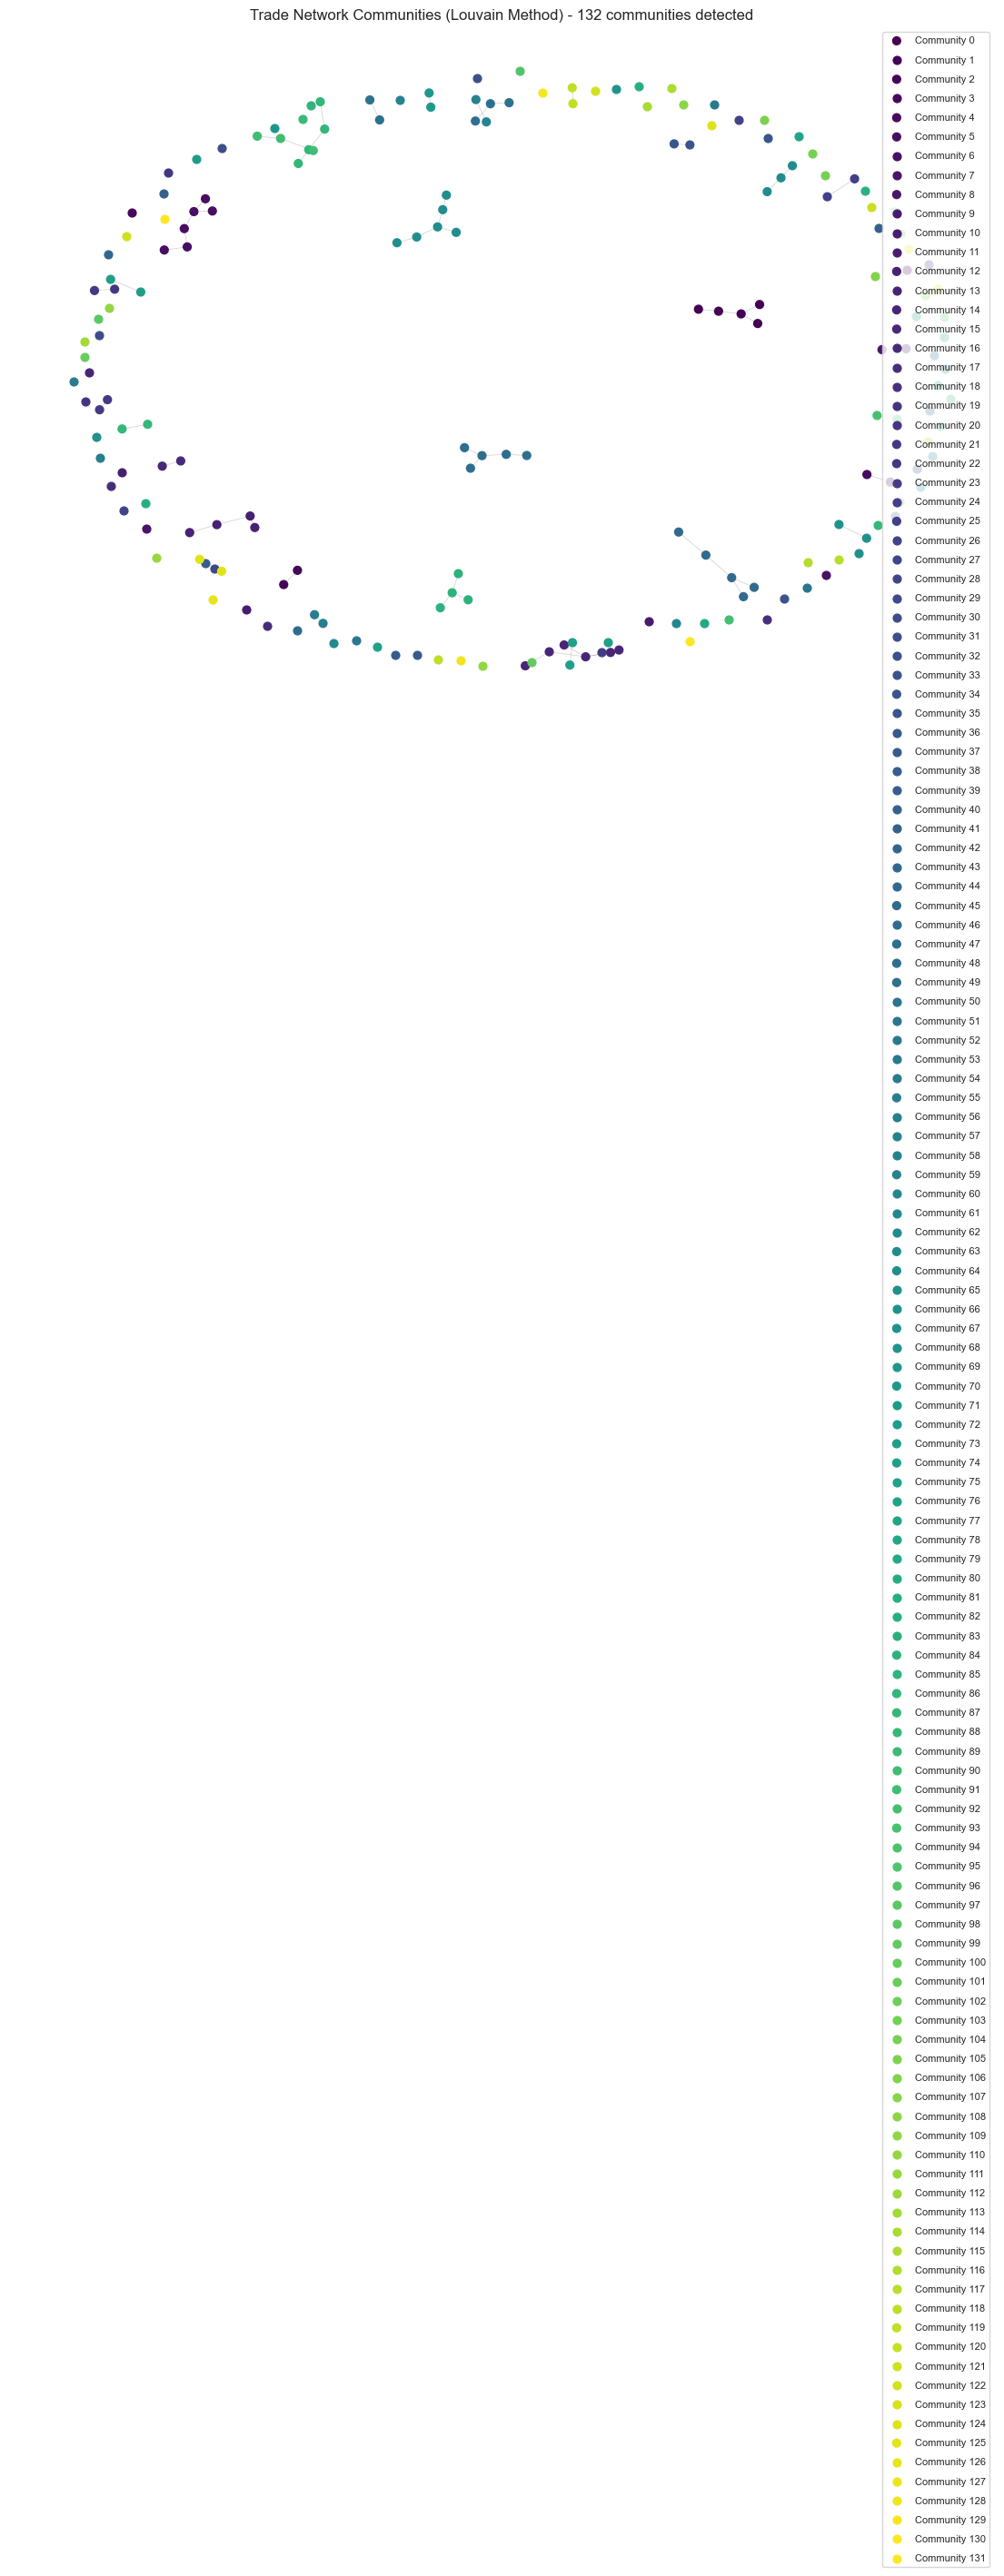

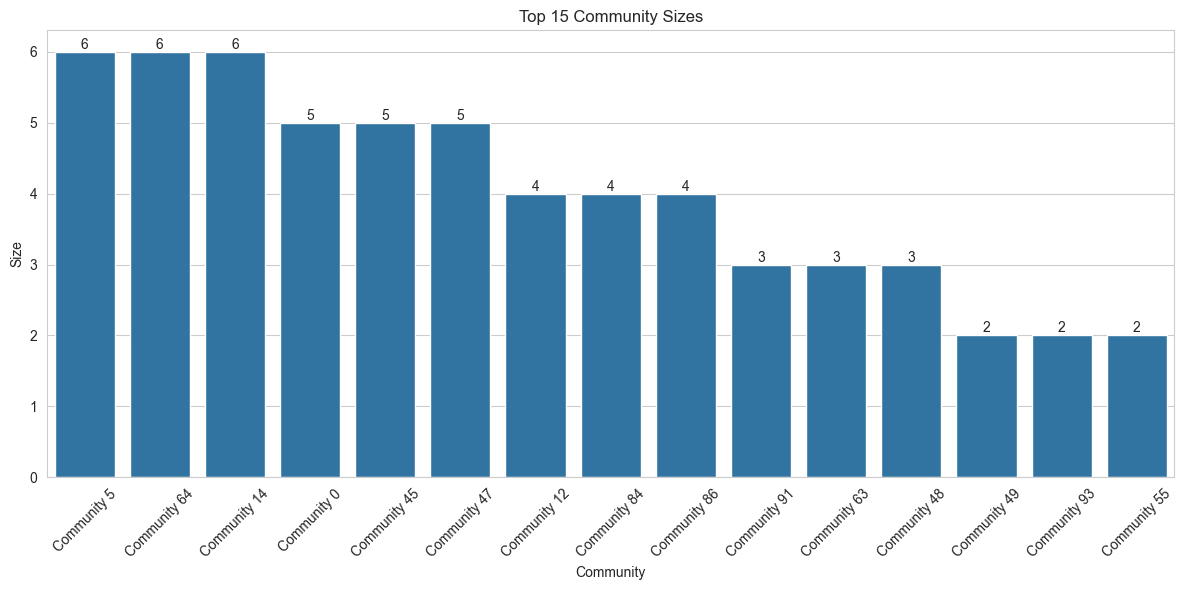

Detected 132 communities in the trade network.
Modularity of the partition: 0.9514
Largest community size: 6 countries
Smallest community size: 1 countries


In [47]:
visualize_communities()

In [48]:
# New enhanced visualization function for the parameterized simulation with centrality highlighting
def run_interactive_simulation(G, friendship_matrix, countries, stats, special_country_id=None):
    # Create a figure with proper spacing
    fig = plt.figure(figsize=(16, 18))
    fig.suptitle('Global Trade Network Simulation Results', fontsize=16)
    
    # Plot 1: Network visualization
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    
    # Use friendship as edge weight for visualization
    edge_weights = [G[u][v]['friendship']*3 for u, v in G.edges()]
    
    # Color edges based on tariffs (red=high tariff, green=low tariff)
    edge_colors = [plt.cm.RdYlGn(1-G[u][v]['tariff']) for u, v in G.edges()]
    
    # Special coloring for reciprocal tariff edges
    reciprocal_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('is_reciprocal', False)]
    non_reciprocal_edges = [(u, v) for u, v in G.edges() if (u, v) not in reciprocal_edges]
    
    # Calculate node centrality measures (betweenness centrality and degree centrality)
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    
    # Combine centrality measures for a more comprehensive view
    combined_centrality = {}
    for node in G.nodes():
        combined_centrality[node] = (betweenness_centrality[node] + degree_centrality[node]) / 2
    
    # Find the most central nodes (top 5%)
    central_nodes = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)
    num_central = max(1, int(len(central_nodes) * 0.05))  # Top 5% or at least 1
    central_nodes = [node for node, score in central_nodes[:num_central]]
    
    # Layout with weighted edges
    pos = nx.spring_layout(G, weight='friendship', k=0.2, seed=42)
    
    # Draw the network with normal edges first
    nx.draw_networkx_edges(G, pos, edgelist=non_reciprocal_edges, 
                          width=edge_weights, alpha=0.5, edge_color=edge_colors, 
                          arrowsize=5, connectionstyle="arc3,rad=0.1")
    
    # Draw reciprocal tariff edges (if any) with a different style
    if reciprocal_edges:
        reciprocal_weights = [G[u][v]['friendship']*3 for u, v in reciprocal_edges]
        reciprocal_colors = ['purple' for _ in reciprocal_edges]  # Purple for reciprocal tariffs
        nx.draw_networkx_edges(G, pos, edgelist=reciprocal_edges, 
                              width=reciprocal_weights, alpha=0.7, edge_color=reciprocal_colors, 
                              arrowsize=7, style='dashed', connectionstyle="arc3,rad=0.1")
    
    # Draw regular nodes
    regular_nodes = [node for node in G.nodes() if node not in central_nodes]
    regular_node_sizes = [20 for _ in regular_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, 
                         node_size=regular_node_sizes, alpha=0.5)
    
    # Draw central nodes with larger size and different color
    if central_nodes:
        central_node_sizes = [max(100, 300 * combined_centrality[node]) for node in central_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=central_nodes, 
                             node_size=central_node_sizes, node_color='gold', alpha=0.8)
        
        # Add labels for central nodes
        central_labels = {node: node for node in central_nodes}
        nx.draw_networkx_labels(G, pos, labels=central_labels, font_size=8, font_color='black')
    
    # Highlight special country if specified
    if special_country_id is not None and special_country_id < len(countries):
        special_country = countries[special_country_id]
        if G.has_node(special_country):
            nx.draw_networkx_nodes(G, pos, nodelist=[special_country], 
                                 node_size=200, node_color='red', alpha=0.8)
            # Add label for special country
            labels = {special_country: special_country}
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')
    
    ax1.set_title(f"Global Trade Network - {G.number_of_edges()} trade relationships")
    ax1.axis('off')
    
    # Add legend for centrality
    if central_nodes:
        central_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', 
                                 markersize=10, label='Central Countries')
        special_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                                  markersize=10, label='Special Tariff Country')
        reciprocal_line = plt.Line2D([0], [0], color='purple', lw=2, linestyle='dashed', 
                                   label='Reciprocal Tariffs')
        normal_line = plt.Line2D([0], [0], color='green', lw=2, 
                               label='Normal Trade')
        high_tariff = plt.Line2D([0], [0], color='red', lw=2, 
                               label='High Tariff')
        
        ax1.legend(handles=[central_patch, special_patch, reciprocal_line, normal_line, high_tariff], 
                 loc='upper right', bbox_to_anchor=(1, 1))
    
    # Plot 2: Trade relationships over time
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    ax2.plot(stats['steps'], stats['num_edges'], 'b-', linewidth=2)
    ax2.set_title('Number of Trade Relationships')
    ax2.set_xlabel('Simulation Steps')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Friendship and tariff over time
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    ax3.plot(stats['steps'], stats['avg_friendship'], 'g-', linewidth=2, label='Avg Friendship')
    ax3.plot(stats['steps'], stats['avg_tariff'], 'r-', linewidth=2, label='Avg Tariff')
    if 'reciprocal_ratio' in stats and stats['reciprocal_ratio']:
        ax3.plot(stats['steps'], stats['reciprocal_ratio'], 'm--', linewidth=2, label='Reciprocal Tariff Ratio')
    ax3.set_title('Trade Relationship Metrics')
    ax3.set_xlabel('Simulation Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot 4: Communities and Polarity Index (if available)
    if 'num_communities' in stats and stats['num_communities']:
        ax4 = plt.subplot2grid((3, 2), (2, 0))
        ax4.plot(stats['steps'], stats['num_communities'], 'm-', linewidth=2)
        ax4.set_title('Number of Trade Communities')
        ax4.set_xlabel('Simulation Steps')
        ax4.set_ylabel('Count')
        ax4.grid(True, alpha=0.3)
        
        ax5 = plt.subplot2grid((3, 2), (2, 1))
        ax5.plot(stats['steps'], stats['polarity_index'], 'c-', linewidth=2)
        ax5.set_title('Polarity Index (Higher = More Unipolar)')
        ax5.set_xlabel('Simulation Steps')
        ax5.set_ylabel('Index')
        ax5.grid(True, alpha=0.3)
        
        # Add horizontal lines for polarity thresholds
        ax5.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Strongly Unipolar')
        ax5.axhline(y=0.3, color='y', linestyle='--', alpha=0.5, label='Moderately Unipolar')
        ax5.axhline(y=0.2, color='g', linestyle='--', alpha=0.5, label='Balanced/Transitional')
        ax5.legend(loc='upper right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print summary statistics
    if G.number_of_edges() > 0:
        print(f"\nSummary Statistics:")
        print(f"  - Final number of trade relationships: {G.number_of_edges()}")
        print(f"  - Average friendship level: {stats['avg_friendship'][-1]:.4f}")
        print(f"  - Average tariff level: {stats['avg_tariff'][-1]:.4f}")
        
        # Reciprocal tariff stats
        if 'reciprocal_ratio' in stats and stats['reciprocal_ratio']:
            reciprocal_pct = stats['reciprocal_ratio'][-1] * 100
            print(f"  - Reciprocal tariff relationships: {reciprocal_pct:.1f}% of all trade")
        
        # Calculate network density
        density = nx.density(G)
        print(f"  - Network density: {density:.4f}")
        
        # Calculate reciprocity (proportion of bilateral trade relationships)
        reciprocity = nx.reciprocity(G)
        print(f"  - Trade reciprocity: {reciprocity:.4f}")
        
        # Centrality analysis
        print(f"\nCentrality Analysis:")
        if central_nodes:
            print(f"  - {len(central_nodes)} central countries identified")
            for i, node in enumerate(central_nodes[:5]):  # Show top 5
                print(f"    {i+1}. {node}: Centrality score = {combined_centrality[node]:.4f}")
            print(f"    (Centrality score combines betweenness and degree centrality)")
            print(f"    (Higher score = more control over global trade flow)")
        
        # Polarity analysis
        polarity_type = analyze_polarity(stats)
        print(f"\nEconomic Structure Analysis:")
        print(f"  - World economy type: {polarity_type}")
        
        if 'num_communities' in stats and stats['num_communities'] and stats['num_communities'][-1] > 0:
            print(f"  - Number of trade communities: {stats['num_communities'][-1]}")
            print(f"  - Largest community size: {stats['largest_community_size'][-1]} countries")
            
            # Detailed explanation of polarity
            if polarity_type == "Strongly Unipolar":
                print("\nThis economy is dominated by a single trade bloc that controls")
                print("a majority of global trade. Other countries are economically dependent.")
            elif polarity_type == "Moderately Unipolar":
                print("\nThis economy has one dominant bloc with significant influence,")
                print("but other trade communities maintain some independence.")
            elif polarity_type == "Balanced/Transitional":
                print("\nThis economy has several trade blocs of similar size")
                print("with balanced influence on global trade.")
            elif polarity_type == "Multipolar":
                print("\nThis economy has many independent trade communities")
                print("with distributed economic power across the globe.")
    else:
        print("No trade relationships remain after the simulation.")

In [49]:
run_interactive_simulation(G, friendship_matrix, countries, stats, special_country_id=None)

NameError: name 'stats' is not defined

# Mean Field Approximation for the Global Trade Simulation

I'll implement a mean field approximation for the global trade network simulation. Mean field theory allows us to approximate complex multi-agent systems by replacing all interactions with an average or "mean" interaction, simplifying the analysis while preserving important system dynamics.

## What is Mean Field Approximation?

Mean field theory is a mathematical technique that replaces all interactions to any one agent with an average interaction. This simplifies N-body problems by reducing them to one-body problems in an effective field. In our trade network:

- Instead of tracking every bilateral trade relationship
- We model how a "typical" country interacts with the average state of the system

## Implementation for the Trade Network Simulation

See next cell


## How Mean Field Theory Simplifies Our Model

The mean field approach provides several advantages:

1. **Computational Efficiency**: Instead of simulating N² possible relationships between N countries, we track just a few global variables.

2. **Analytical Insights**: Makes it easier to understand system equilibria, tipping points, and stability conditions.

3. **Long-term Trends**: Shows the expected evolution of the system in terms of average properties.

## Key Mean Field Variables

- **Average Friendship**: The mean friendship level across all country pairs
- **Average Tariff**: The mean tariff level applied by countries
- **Network Connectivity**: The proportion of all possible connections actually formed
- **Polarity Estimate**: How concentrated economic power is (unipolar vs. multipolar)

## Limitations of Mean Field Approximation

This approach does lose information about:

1. **Heterogeneity**: Individual differences between countries are averaged out
2. **Network Structure**: Specific topology details are lost
3. **Local Dynamics**: Effects that depend on particular connections

Nevertheless, it provides valuable insights into the overall system behavior and trends with much less computational complexity.

## Comparing with Agent-Based Simulation

The full agent-based simulation and this mean field approximation complement each other:
- The agent simulation shows emergent patterns and heterogeneity
- The mean field model reveals underlying dynamics and general trends

Together, they give a more complete understanding of global trade dynamics.

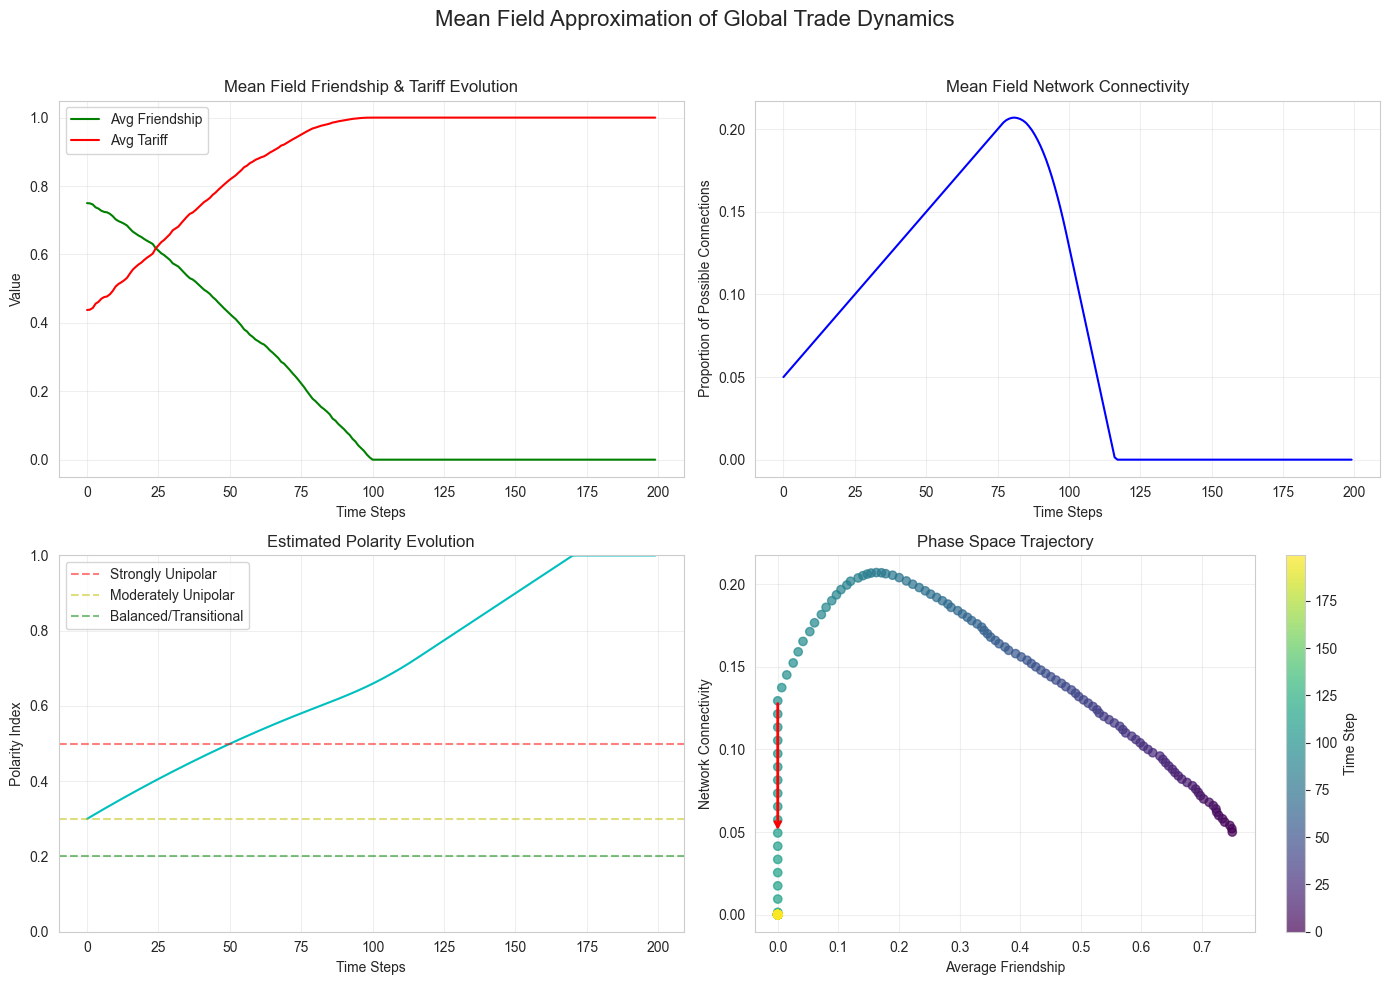

Mean Field Approximation Summary:
- Final average friendship: 0.0000
- Final average tariff: 1.0000
- Final network connectivity: 0.0000
- Final polarity state: Strongly Unipolar (1.0000)


In [50]:
# Mean Field Approximation for Global Trade Simulation
def mean_field_approximation(num_countries, num_steps, friendship_threshold=0.2, 
                            initial_friendship=0.75, tariff_policy='default',
                            connection_probability=0.05):
    """
    Implements a mean field approximation of the trade network simulation.
    
    Instead of simulating each individual country pair, we approximate the system
    by tracking average global properties and how a typical country evolves.
    """
    # Initialize statistics tracking
    stats = {
        'step': np.arange(num_steps),
        'avg_friendship': np.zeros(num_steps),
        'avg_tariff': np.zeros(num_steps),
        'connectivity': np.zeros(num_steps),  # % of possible connections actually formed
        'polarity_estimate': np.zeros(num_steps)
    }
    
    # Initial conditions
    stats['avg_friendship'][0] = initial_friendship
    
    # Apply initial tariff based on policy
    if tariff_policy == 'default':
        stats['avg_tariff'][0] = 1.0 - initial_friendship**2
    elif tariff_policy == 'high':
        stats['avg_tariff'][0] = 0.85
    elif tariff_policy == 'low':
        stats['avg_tariff'][0] = 0.15
    elif tariff_policy == 'random':
        stats['avg_tariff'][0] = 0.5
    else:  # bloc-based approximation
        stats['avg_tariff'][0] = 0.4
    
    # Initial connectivity (proportion of all possible connections)
    stats['connectivity'][0] = connection_probability
    
    # Initial estimate of polarity (0: perfectly multipolar, 1: perfectly unipolar)
    stats['polarity_estimate'][0] = 0.3  # Starting with moderate polarity
    
    # Mean field evolution equations
    for t in range(1, num_steps):
        # 1. Friendship evolution based on average tariff impact
        friendship_change = -stats['avg_tariff'][t-1] * 0.01
        
        # Add small random perturbation to model stochasticity in the system
        perturbation = np.random.normal(0, 0.002)
        new_friendship = stats['avg_friendship'][t-1] + friendship_change + perturbation
        stats['avg_friendship'][t] = np.clip(new_friendship, 0, 1)
        
        # 2. Tariff evolution based on average friendship
        stats['avg_tariff'][t] = 1.0 - stats['avg_friendship'][t]**2
        
        # 3. Connectivity evolution
        # - Decreases when friendship is low (edges removed)
        # - New random connections form at a small rate
        edge_removal_rate = max(0, (friendship_threshold - stats['avg_friendship'][t]) * 0.05)
        new_edge_rate = 0.002  # 0.2% new random connections per step
        
        connectivity_change = new_edge_rate - edge_removal_rate
        stats['connectivity'][t] = np.clip(stats['connectivity'][t-1] + connectivity_change, 0, 1)
        
        # 4. Polarity evolution (tendency toward unipolarity when connectivity declines)
        # Higher connectivity generally favors multipolarity
        polarity_change = (0.5 - stats['connectivity'][t]) * 0.01  # Drift toward unipolarity when connectivity is low
        stats['polarity_estimate'][t] = np.clip(stats['polarity_estimate'][t-1] + polarity_change, 0, 1)
    
    return stats

# Function to visualize mean field approximation results
def plot_mean_field_results(stats):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Mean Field Approximation of Global Trade Dynamics', fontsize=16)
    
    # Plot 1: Friendship and Tariff Evolution
    axs[0, 0].plot(stats['step'], stats['avg_friendship'], 'g-', label='Avg Friendship')
    axs[0, 0].plot(stats['step'], stats['avg_tariff'], 'r-', label='Avg Tariff')
    axs[0, 0].set_title('Mean Field Friendship & Tariff Evolution')
    axs[0, 0].set_xlabel('Time Steps')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].legend()
    
    # Plot 2: Network Connectivity
    axs[0, 1].plot(stats['step'], stats['connectivity'], 'b-')
    axs[0, 1].set_title('Mean Field Network Connectivity')
    axs[0, 1].set_xlabel('Time Steps')
    axs[0, 1].set_ylabel('Proportion of Possible Connections')
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Polarity Index (unipolarity vs. multipolarity)
    axs[1, 0].plot(stats['step'], stats['polarity_estimate'], 'c-')
    axs[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Strongly Unipolar')
    axs[1, 0].axhline(y=0.3, color='y', linestyle='--', alpha=0.5, label='Moderately Unipolar')
    axs[1, 0].axhline(y=0.2, color='g', linestyle='--', alpha=0.5, label='Balanced/Transitional')
    axs[1, 0].set_title('Estimated Polarity Evolution')
    axs[1, 0].set_xlabel('Time Steps')
    axs[1, 0].set_ylabel('Polarity Index')
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()
    
    # Plot 4: Phase diagram (Friendship vs. Connectivity)
    p = axs[1, 1].scatter(stats['avg_friendship'], stats['connectivity'], 
                  c=stats['step'], cmap='viridis', alpha=0.7)
    axs[1, 1].set_title('Phase Space Trajectory')
    axs[1, 1].set_xlabel('Average Friendship')
    axs[1, 1].set_ylabel('Network Connectivity')
    axs[1, 1].grid(True, alpha=0.3)
    cbar = fig.colorbar(p, ax=axs[1, 1])
    cbar.set_label('Time Step')
    
    # Add arrow showing direction of evolution
    mid_point = len(stats['step']) // 2
    axs[1, 1].annotate('', 
                xy=(stats['avg_friendship'][mid_point+10], stats['connectivity'][mid_point+10]),
                xytext=(stats['avg_friendship'][mid_point], stats['connectivity'][mid_point]),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Print summary
    print(f"Mean Field Approximation Summary:")
    print(f"- Final average friendship: {stats['avg_friendship'][-1]:.4f}")
    print(f"- Final average tariff: {stats['avg_tariff'][-1]:.4f}")
    print(f"- Final network connectivity: {stats['connectivity'][-1]:.4f}")
    
    # Interpret polarity
    final_polarity = stats['polarity_estimate'][-1]
    if final_polarity > 0.5:
        polarity_type = "Strongly Unipolar"
    elif final_polarity > 0.3:
        polarity_type = "Moderately Unipolar"
    elif final_polarity > 0.2:
        polarity_type = "Balanced/Transitional"
    else:
        polarity_type = "Multipolar"
    print(f"- Final polarity state: {polarity_type} ({final_polarity:.4f})")

# Run the mean field approximation
mean_field_stats = mean_field_approximation(
    num_countries=50, 
    num_steps=200,
    friendship_threshold=0.2,
    initial_friendship=0.75,
    tariff_policy='default'
)

# Visualize the results
plot_mean_field_results(mean_field_stats)